# Tutorial 2: Differentiable programming

[Julia and its ecosystem provide some tools for differentiable programming](https://sinews.siam.org/Details-Page/scientific-machine-learning-how-julia-employs-differentiable-programming-to-do-it-best).
Trixi.jl is designed to be flexible, extendable, and composable with Julia's growing ecosystem for
scientific computing and machine learning. Thus, the ultimate goal is to have fast implementations
that allow automatic differentiation (AD) without too much hassle for users. If some parts do not
meet these requirements, please feel free to open an issue or propose a fix in a PR.

In the following, we will walk through some examples demonstrating how to differentiate through
Trixi.jl.

## Forward mode automatic differentiation

Trixi integrates well with [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl)
for forward mode AD.

### Computing the Jacobian
The high-level interface to compute the Jacobian this way is [`jacobian_ad_forward`](https://trixi-framework.github.io/Trixi.jl/v0.3.51/reference-trixi/#Trixi.jacobian_ad_forward-Tuple{Trixi.AbstractSemidiscretization}).

In [1]:
using Trixi, LinearAlgebra, Plots

In [2]:
equations = CompressibleEulerEquations2D(1.4);

solver = DGSEM(3, flux_central);

mesh = TreeMesh((-1.0, -1.0), (1.0, 1.0), initial_refinement_level=2, n_cells_max=10^5);

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition_density_wave, solver);

J = jacobian_ad_forward(semi);

size(J)

(1024, 1024)

In [3]:
λ = eigvals(J);

scatter(real.(λ), imag.(λ));

3.0e-10 < maximum(real, λ) / maximum(abs, λ) < 8.0e-10

true

In [4]:
1.0e-7 < maximum(real, λ) < 5.0e-7

true

Interestingly, if we add dissipation by switching to the `flux_lax_friedrichs` at the interfaces,
the maximal real part of the eigenvalues increases.

In [5]:
solver = DGSEM(3, flux_lax_friedrichs);

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition_density_wave, solver);

J = jacobian_ad_forward(semi);

λ = eigvals(J);

scatter!(real.(λ), imag.(λ));

λ = eigvals(J); round(maximum(real, λ) / maximum(abs, λ), sigdigits=2)

2.1e-5

In [6]:
round(maximum(real, λ), sigdigits=2)

0.0057

However, we should be careful when using this analysis, since the eigenvectors are not necessarily
well-conditioned.

In [7]:
λ, V = eigen(J);

round(cond(V), sigdigits=2)

1.8e6

In one space dimension, the situation is a bit different.

In [8]:
equations = CompressibleEulerEquations1D(1.4);

solver = DGSEM(3, flux_central);

mesh = TreeMesh((-1.0,), (1.0,), initial_refinement_level=6, n_cells_max=10^5);

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition_density_wave, solver);

J = jacobian_ad_forward(semi);

λ = eigvals(J);

scatter(real.(λ), imag.(λ));

1.0e-16 < maximum(real, λ) / maximum(abs, λ) < 6.0e-16

true

In [9]:
1.0e-12 < maximum(real, λ) < 6.0e-12

true

In [10]:
λ, V = eigen(J);

200 < cond(V) < 300

true

If we add dissipation, the maximal real part is still approximately zero.

In [11]:
solver = DGSEM(3, flux_lax_friedrichs);

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition_density_wave, solver);

J = jacobian_ad_forward(semi);

λ = eigvals(J);

scatter!(real.(λ), imag.(λ));

λ = eigvals(J);

1.0e-18 < maximum(real, λ) / maximum(abs, λ) < 1.0e-16

true

In [12]:
5.0e-14 < maximum(real, λ) < 7.0e-13

true

In [13]:
λ, V = eigen(J);

90_000 < cond(V) < 100_000

false

Note that the condition number of the eigenvector matrix increases but is still smaller than for the
example in 2D.

### Computing other derivatives

It is also possible to compute derivatives of other dependencies using AD in Trixi. For example,
you can compute the gradient of an entropy-dissipative semidiscretization with respect to the
ideal gas constant of the compressible Euler equations as described in the following. This example
is also available as the elixir
[examples/special\_elixirs/elixir\_euler\_ad.jl](https://github.com/trixi-framework/Trixi.jl/blob/main/examples/special_elixirs/elixir_euler_ad.jl)

In [14]:
using Trixi, LinearAlgebra, ForwardDiff

In [15]:
equations = CompressibleEulerEquations2D(1.4);

mesh = TreeMesh((-1.0, -1.0), (1.0, 1.0), initial_refinement_level=2, n_cells_max=10^5);

solver = DGSEM(3, flux_lax_friedrichs, VolumeIntegralFluxDifferencing(flux_ranocha));

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition_isentropic_vortex, solver)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 2                                                                │
│ mesh: ………………………………………………………………… TreeMesh{2, Trixi.SerialTree{2}} with length 21                  │
│ equations: …………………………………………………… CompressibleEulerEquations2D                                     │
│ initial condition: ……………………………… initial_condition_isentropic_vortex                              │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  │
│ source terms: …………………………………………… nothing                                                          │
│ solver: …………………………………………………………… DG                                                       

In [16]:
u0_ode = compute_coefficients(0.0, semi);

size(u0_ode)

(1024,)

In [17]:
J = ForwardDiff.jacobian((du_ode, γ) -> begin
        equations_inner = CompressibleEulerEquations2D(first(γ))
        semi_inner = Trixi.remake(semi, equations=equations_inner, uEltype=eltype(γ));
        Trixi.rhs!(du_ode, u0_ode, semi_inner, 0.0)
    end, similar(u0_ode), [1.4]); # γ needs to be an `AbstractArray`

round.(extrema(J), sigdigits=2)

(-5.6, 5.6)

Note that we create a semidiscretization `semi` at first to determine the state `u0_ode` around
which we want to perform the linearization. Next, we wrap the RHS evaluation inside a closure
and pass that to `ForwardDiff.jacobian`. There, we need to make sure that the internal caches
are able to store dual numbers from ForwardDiff.jl by setting `uEltype` appropriately. A similar
approach is used by [`jacobian_ad_forward`](https://trixi-framework.github.io/Trixi.jl/v0.3.51/reference-trixi/#Trixi.jacobian_ad_forward-Tuple{Trixi.AbstractSemidiscretization}).

Note that the ideal gas constant does not influence the semidiscrete rate of change of the
density, as demonstrated by

In [18]:
norm(J[1:4:end])

0.0

Here, we used some knowledge about the internal memory layout of Trixi, an array of structs
with the conserved variables as fastest-varying index in memory.

## Differentiating through a complete simulation

It is also possible to differentiate through a complete simulation. As an example, let's differentiate
the total energy of a simulation using the linear scalar advection equation with respect to the
wave number (frequency) of the initial data.

In [19]:
using Trixi, OrdinaryDiffEq, ForwardDiff, Plots

function energy_at_final_time(k) # k is the wave number of the initial condition
    equations = LinearScalarAdvectionEquation2D(1.0, -0.3)
    mesh = TreeMesh((-1.0, -1.0), (1.0, 1.0), initial_refinement_level=3, n_cells_max=10^4)
    solver = DGSEM(3, flux_lax_friedrichs)
    initial_condition = (x, t, equation) -> begin
            x_trans = Trixi.x_trans_periodic_2d(x - equation.advectionvelocity * t)
            return SVector(sinpi(k * sum(x_trans)))
    end
    semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, solver,
                                               uEltype=typeof(k))
    ode = semidiscretize(semi, (0.0, 1.0))
    sol = solve(ode, BS3(), save_everystep=false)
    Trixi.integrate(energy_total, sol.u[end], semi)
end

energy_at_final_time (generic function with 1 method)

In [20]:
k_values = range(0.9, 1.1, length=101)

0.9:0.002:1.1

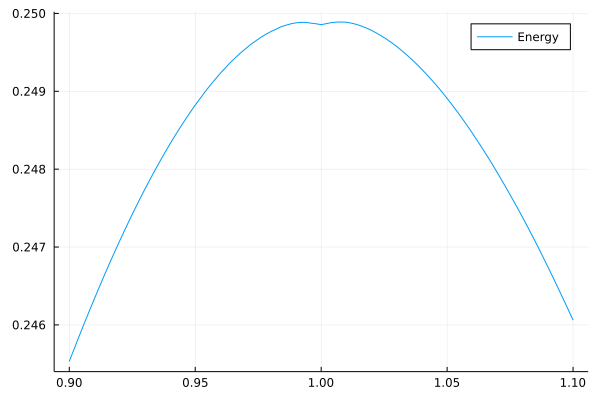

In [21]:
plot(k_values, energy_at_final_time.(k_values), label="Energy")

You should see a plot of a curve that resembles a parabola with local maximum around `k = 1.0`.
Why's that? Well, the domain is fixed but the wave number changes. Thus, if the wave number is
not chosen as an integer, the initial condition will not be a smooth periodic function in the
given domain. Hence, the dissipative surface flux (`flux_lax_friedrichs` in this example)
will introduce more dissipation. In particular, it will introduce more dissipation for "less smooth"
initial data, corresponding to wave numbers `k` further away from integers.

We can compute the discrete derivative of the energy at the final time with respect to the wave
number `k` as follows.

In [22]:
round(ForwardDiff.derivative(energy_at_final_time, 1.0), sigdigits=2)

1.4e-5

This is rather small and we can treat it as zero in comparison to the value of this derivative at
other wave numbers `k`.

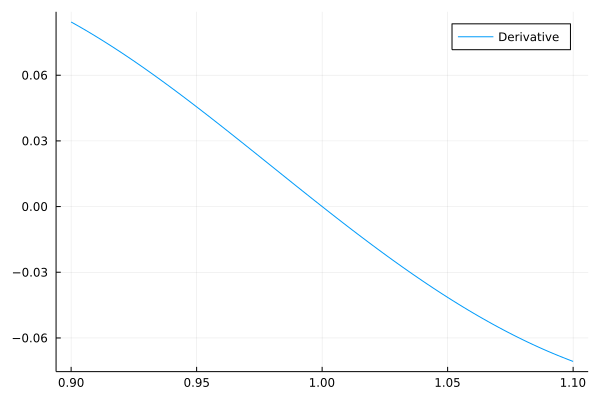

In [23]:
dk_values = ForwardDiff.derivative.((energy_at_final_time,), k_values);

plot(k_values, dk_values, label="Derivative")

If you remember basic calculus, a sufficient condition for a local maximum is that the first derivative
vanishes and the second derivative is negative. We can also check this discretely.

In [24]:
# advection_differentiate_simulation
round(ForwardDiff.derivative(
        k -> Trixi.ForwardDiff.derivative(energy_at_final_time, k), 1.0),
      sigdigits=2)

-0.9

Having seen this application, let's break down what happens step by step.

In [25]:
function energy_at_final_time(k) # k is the wave number of the initial condition
    equations = LinearScalarAdvectionEquation2D(1.0, -0.3)
    mesh = TreeMesh((-1.0, -1.0), (1.0, 1.0), initial_refinement_level=3, n_cells_max=10^4)
    solver = DGSEM(3, flux_lax_friedrichs)
    initial_condition = (x, t, equation) -> begin
        x_trans = Trixi.x_trans_periodic_2d(x - equation.advectionvelocity * t)
        return SVector(sinpi(k * sum(x_trans)))
    end
    semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, solver,
                                               uEltype=typeof(k))
    ode = semidiscretize(semi, (0.0, 1.0))
    sol = solve(ode, BS3(), save_everystep=false)
    Trixi.integrate(energy_total, sol.u[end], semi)
end

k = 1.0
round(ForwardDiff.derivative(energy_at_final_time, k), sigdigits=2)

1.4e-5

When calling `ForwardDiff.derivative(energy_at_final_time, k)` with `k=1.0`, ForwardDiff.jl
will basically use the chain rule and known derivatives of existing basic functions
to calculate the derivative of the energy at the final time with respect to the
wave number `k` at `k0 = 1.0`. To do this, ForwardDiff.jl uses dual numbers, which
basically store the result and its derivative w.r.t. a specified parameter at the
same time. Thus, we need to make sure that we can treat these `ForwardDiff.Dual`
numbers everywhere during the computation. Fortunately, generic Julia code usually
supports these operations. The most basic problem for a developer is to ensure
that all types are generic enough, in particular the ones of internal caches.

The first step in this example creates some basic ingredients of our simulation.

In [26]:
equations = LinearScalarAdvectionEquation2D(1.0, -0.3)
mesh = TreeMesh((-1.0, -1.0), (1.0, 1.0), initial_refinement_level=3, n_cells_max=10^4)
solver = DGSEM(3, flux_lax_friedrichs)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DG{Float64}                                                                                      │
│ ═══════════                                                                                      │
│ basis: ……………………………………………………………… LobattoLegendreBasis{Float64}(polydeg=3)                         │
│ mortar: …………………………………………………………… LobattoLegendreMortarL2{Float64}(polydeg=3)                      │
│ surface integral: ………………………………… SurfaceIntegralWeakForm                                          │
│ │ surface flux: ……………………………………… FluxLaxFriedrichs(max_abs_speed_naive)                           │
│ volume integral: …………………………………… VolumeIntegralWeakForm                                           │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

These do not have internal caches storing intermediate values of the numerical
solution, so we do not need to adapt them. In fact, we could also define them
outside of `energy_at_final_time` (but would need to take care of globals or
wrap everything in another function).

Next, we define the initial condition

In [27]:
initial_condition = (x, t, equation) -> begin
    x_trans = Trixi.x_trans_periodic_2d(x - equation.advectionvelocity * t)
    return SVector(sinpi(k * sum(x_trans)))
end

#9 (generic function with 1 method)

as a closure capturing the wave number `k` passed to `energy_at_final_time`.
If you call `energy_at_final_time(1.0)`, `k` will be a `Float64`. Thus, the
return values of `initial_condition` will be `SVector`s of `Float64`s. When
calculating the `ForwardDiff.derivative`, `k` will be a `ForwardDiff.Dual` number.
Hence, the `initial_condition` will return `SVector`s of `ForwardDiff.Dual`
numbers.

The semidiscretization `semi` uses some internal caches to avoid repeated allocations
and speed up the computations, e.g. for numerical fluxes at interfaces. Thus, we
need to tell Trixi to allow `ForwardDiff.Dual` numbers in these caches. That's what
the keyword argument `uEltype=typeof(k)` in

In [28]:
semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, solver,
                                    uEltype=typeof(k))

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 2                                                                │
│ mesh: ………………………………………………………………… TreeMesh{2, Trixi.SerialTree{2}} with length 85                  │
│ equations: …………………………………………………… LinearScalarAdvectionEquation2D                                  │
│ initial condition: ……………………………… #9                                                               │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  │
│ source terms: …………………………………………… nothing                                                          │
│ solver: …………………………………………………………… DG                                                       

does. This is basically the only part where you need to modify your standard Trixi
code to enable automatic differentiation. From there on, the remaining steps

In [29]:
ode = semidiscretize(semi, (0.0, 1.0))
sol = solve(ode, BS3(), save_everystep=false)
Trixi.integrate(energy_total, sol.u[end], semi)

0.24985580923677064

do not need any modifications since they are sufficiently generic (and enough effort
has been spend to allow general types inside these calls).

## Propagating errors using Measurements.jl

[![Error bars by Randall Munroe](https://imgs.xkcd.com/comics/error_bars.png)](https://xkcd.com/2110/)

Similar to AD, Trixi also allows propagating uncertainties using linear error propagation
theory via [Measurements.jl](https://github.com/JuliaPhysics/Measurements.jl).
As an example, let's create a system representing the linear advection equation
in 1D with an uncertain velocity. Then, we create a semidiscretization using a
sine wave as initial condition, solve the ODE, and plot the resulting uncertainties
in the primitive variables.

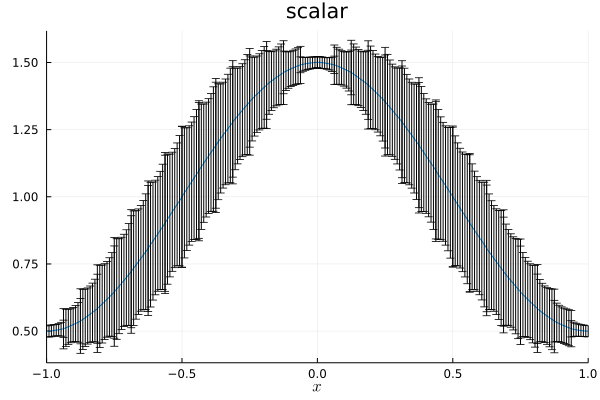

In [30]:
using Trixi, OrdinaryDiffEq, Measurements, Plots, LaTeXStrings

equations = LinearScalarAdvectionEquation1D(1.0 ± 0.1);

mesh = TreeMesh((-1.0,), (1.0,), n_cells_max=10^5, initial_refinement_level=5);

solver = DGSEM(3);

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition_convergence_test,
                                    solver, uEltype=Measurement{Float64});

ode = semidiscretize(semi, (0.0, 1.5));

sol = solve(ode, BS3(), save_everystep=false);

plot(sol)

You should see a plot like this, where small error bars are shown around
the extrema and larger error bars are shown in the remaining parts. This result
is in accordance with expectations. Indeed, the uncertain propagation speed will
affect the extrema less since the local variation of the solution is relatively
small there. In contrast, the local variation of the solution is large around
the turning points of the sine wave, so the uncertainties will be relatively
large there.

All this is possible due to allowing generic types and having good abstractions
in Julia that allow packages to work together seamlessly.

## Finite difference approximations

Trixi provides the convenience function [`jacobian_fd`](https://trixi-framework.github.io/Trixi.jl/v0.3.51/reference-trixi/#Trixi.jacobian_fd-Tuple{Trixi.AbstractSemidiscretization}) to approximate the Jacobian
via central finite differences.

In [31]:
using Trixi, LinearAlgebra

equations = CompressibleEulerEquations2D(1.4);

solver = DGSEM(3, flux_central);

mesh = TreeMesh((-1.0, -1.0), (1.0, 1.0), initial_refinement_level=2, n_cells_max=10^5);

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition_density_wave, solver);

J_fd = jacobian_fd(semi);

J_ad = jacobian_ad_forward(semi);

round(norm(J_fd - J_ad) / size(J_fd, 1), sigdigits=2)

5.9e-7

This discrepancy is of the expected order of magnitude for central finite difference approximations.

## Linear systems

When a linear PDE is discretized using a linear scheme such as a standard DG method,
the resulting semidiscretization yields an affine ODE of the form

$$
\partial_t u(t) = A u(t) + b,
$$

where `A` is a linear operator ("matrix") and `b` is a vector. Trixi allows you
to obtain this linear structure in a matrix-free way by using [`linear_structure`](https://trixi-framework.github.io/Trixi.jl/v0.3.51/reference-trixi/#Trixi.linear_structure-Tuple{Trixi.AbstractSemidiscretization}).
The resulting operator `A` can be used in multiplication, e.g. `mul!` from
LinearAlgebra, converted to a sparse matrix using `sparse` from SparseArrays,
or converted to a dense matrix using `Matrix` for detailed eigenvalue analyses.
For example,

In [32]:
using Trixi, LinearAlgebra, Plots

equations = LinearScalarAdvectionEquation2D(1.0, -0.3);

solver = DGSEM(3, flux_lax_friedrichs);

mesh = TreeMesh((-1.0, -1.0), (1.0, 1.0), initial_refinement_level=2, n_cells_max=10^5);

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition_convergence_test, solver);

A, b = linear_structure(semi);

size(A), size(b)

((256, 256), (256,))

In [33]:
λ = eigvals(Matrix(A));

scatter(real.(λ), imag.(λ));

λ = eigvals(Matrix(A)); maximum(real, λ) / maximum(abs, λ) < 1.0e-15

true